In [1]:
import os
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score

warnings.filterwarnings('ignore')

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory path to save results

In [3]:
output_dir = '../results/updated_data/all_features/ovarianCancer/LPO_validation/binary/'

Load dataset

In [4]:
data_path = '../data/cleaned/updated/all_features/ovarianCancer/'

dataset = pd.read_csv(os.path.join(data_path, 'dataset.csv'), sep=';')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Columns: 5331 entries, ID to CASC15
dtypes: float64(5327), object(4)
memory usage: 5.2+ MB


Prepare data for validation

In [5]:
dataset_binary = dataset.copy(deep=True)

binary_mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
dataset_binary.loc[:, 'Stage'] = dataset_binary['Stage'].map(binary_mapping)
dataset_binary = dataset_binary.loc[:, ~dataset_binary.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding_binary = {
    'I-III': 0,
    'IV': 1
}
dataset_binary.loc[:, 'Stage'] = dataset_binary['Stage'].map(labels_encoding_binary)

Define functions and classes neccassary to run experiment

In [6]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores

In [7]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=5
    )

    return scores.mean()

In [8]:
class NoisyOverSampler:
    
    def __init__(self, n_new_samples, noise_range, equal_noise_value=False, equalize_imbalance=False):
        self.n_new_samples = n_new_samples
        self.noise_range = noise_range
        self.equal_noise_value = equal_noise_value
        self.equalize_imbalance = equalize_imbalance
        
    def _get_n_new_samples_per_class(self, y):
        if not self.equalize_imbalance:
            n_new_samples_per_class = {class_: self.n_new_samples for class_ in y.unique()}
            return n_new_samples_per_class
        
        else:
            class_counts = y.value_counts()
            max_counts = class_counts.max()
            
            n_new_samples_per_class = {class_: (max_counts / counts) * self.n_new_samples + (max_counts - counts) / counts
                                       for class_, counts in class_counts.items()}
                
            return n_new_samples_per_class
    
    def _generate_new_samples(self, x_sample, n_new_samples):
        if self.equal_noise_value:
            x_new_samples = np.array([x_sample + np.full(x_sample.size, np.random.uniform(-self.noise_range, self.noise_range, 1)[0])
                                    for _ in range(n_new_samples)])
            return x_new_samples
        
        else:
            x_new_samples = np.array([x_sample + np.random.uniform(-self.noise_range, self.noise_range, x_sample.size)
                                      for _ in range(n_new_samples)])
            return x_new_samples
            
    
    def fit_resample(self, X, y):
        n_new_samples_per_class = self._get_n_new_samples_per_class(y)
        
        X_resampled = X.values.copy()
        y_resampled = y.values.copy()
        
        for x_sample, y_sample in zip(X.values, y.values):
            n_new_samples = int(n_new_samples_per_class[y_sample])
            
            if np.random.random() < n_new_samples_per_class[y_sample] % 1:
                n_new_samples += 1
            
            y_new_samples = np.full(n_new_samples, fill_value=y_sample)
            x_new_samples = self._generate_new_samples(x_sample, n_new_samples)
            
            y_resampled = np.concatenate((y_resampled, y_new_samples))
            X_resampled = np.concatenate((X_resampled, x_new_samples))
        
        return X_resampled, y_resampled

In [9]:
def leave_pair_out_folds(y: np.array):
    all_indices = np.arange(y.size)
    positive_indices = np.flatnonzero(y == 1)
    negative_indices = np.flatnonzero(y == 0)
    
    for positive_idx in positive_indices:
        for negative_idx in negative_indices:
            test_indices = np.array([positive_idx, negative_idx])
            train_indices = np.setdiff1d(all_indices, test_indices)
            
            yield train_indices, test_indices

def get_n_leave_pair_out_splits(y: np.array):
    n_positive = y[y == 1].size
    n_negative = y[y == 0].size
    
    return n_positive * n_negative

In [10]:
def get_feature_importances(X_train, y_train, classifier):
    classifier.fit(X=X_train, y=y_train, verbose=False)
    feature_importances = classifier.feature_importances_
    
    return feature_importances

def select_by_percentile(scores, percentile):
    threshold = np.percentile(scores, percentile)

    return np.where(scores > threshold)

def backward_features_elimination(X_train, y_train, classifier, max_features):
    best_features = X_train.columns
    best_feature_indices = np.arange(len(best_features))
    
    while len(best_features) > max_features:
        feature_importances = get_feature_importances(X_train.loc[:, best_features], y_train, classifier)
        feature_indices = select_by_percentile(feature_importances, 50)
        best_feature_indices = best_feature_indices[feature_indices]
        best_features = best_features[feature_indices]
        
    return best_features, best_feature_indices

In [20]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

In [107]:
def plot_feature_importances(feature_importances_history, feature_names, top_n=25, output_path=None):
    mean_importance_scores = np.mean(feature_importances_history, axis=0)
    top_feature_indices = np.argsort(mean_importance_scores)[-1:-top_n-1:-1]
    
    top_feature_importances = feature_importances_history[:, top_feature_indices]
    top_feature_names = feature_names[top_feature_indices]
    
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=top_feature_importances, orient='h', color='#0466C8', linewidth=0.7, fliersize=1.8)
    ax.set_ylabel('Feature Name')
    ax.set_xlabel('Importance Score')
    plt.title(f'Top {top_n} most important features from leave-pair-out cross-validation (by mean score)', y=1.02, fontsize=14)
    ax.set_yticklabels(top_feature_names)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

### Hyperparameters optimization

In [11]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}

objective_func = partial(
    objective,
    X_train=dataset_binary,
    stratification_groups=dataset_binary.loc[:, 'Stage'],
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

storage = f'sqlite:///{output_dir}/xgb_hyperparameters_study.db'
study = optuna.create_study(storage=storage, direction='maximize')
study.optimize(objective_func, n_trials=300)

best_params = {
    **study.best_params,
    **xgb_config
}

[I 2023-10-29 02:36:41,365] A new study created in RDB with name: no-name-857e9e45-ec47-4e44-bde9-371c2581860b
[I 2023-10-29 02:36:56,700] Trial 0 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 104, 'max_depth': 7, 'learning_rate': 0.02230815846350054, 'subsample': 0.8767087691410731, 'colsample_bytree': 0.6615187200311377, 'gamma': 0.6005444276041286}. Best is trial 0 with value: 0.8751879699248122.
[I 2023-10-29 02:37:09,252] Trial 1 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 84, 'max_depth': 2, 'learning_rate': 0.1199855039399929, 'subsample': 0.8068885586444835, 'colsample_bytree': 0.7358713569735609, 'gamma': 0.7815390990594103}. Best is trial 0 with value: 0.8751879699248122.
[I 2023-10-29 02:37:28,850] Trial 2 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 143, 'max_depth': 7, 'learning_rate': 0.021534138626684143, 'subsample': 0.7573530341244391, 'colsample_bytree': 0.7187333742804486, 'gamma': 0.

[I 2023-10-29 02:42:35,392] Trial 25 finished with value: 0.8699248120300751 and parameters: {'n_estimators': 99, 'max_depth': 6, 'learning_rate': 0.027732479690317488, 'subsample': 0.8432001974949542, 'colsample_bytree': 0.6395201327448954, 'gamma': 0.6305451175440594}. Best is trial 0 with value: 0.8751879699248122.
[I 2023-10-29 02:42:47,815] Trial 26 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 82, 'max_depth': 8, 'learning_rate': 0.052017425976810375, 'subsample': 0.7913530003105447, 'colsample_bytree': 0.6913129719993868, 'gamma': 0.9182146811654752}. Best is trial 0 with value: 0.8751879699248122.
[I 2023-10-29 02:43:03,482] Trial 27 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 137, 'max_depth': 6, 'learning_rate': 0.08598137176339735, 'subsample': 0.7525807188962389, 'colsample_bytree': 0.7337453744639313, 'gamma': 0.9838423303070021}. Best is trial 0 with value: 0.8751879699248122.
[I 2023-10-29 02:43:15,045] Trial 28 fin

[I 2023-10-29 02:46:20,316] Trial 50 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 62, 'max_depth': 4, 'learning_rate': 0.05076361287837551, 'subsample': 0.8625097657736369, 'colsample_bytree': 0.6784201680250088, 'gamma': 0.5221760178156969}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:46:27,823] Trial 51 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 0.0152594512612396, 'subsample': 0.831239919235963, 'colsample_bytree': 0.6408851616362184, 'gamma': 0.6667211347969136}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:46:34,725] Trial 52 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 25, 'max_depth': 3, 'learning_rate': 0.021451471320497118, 'subsample': 0.8063052635986242, 'colsample_bytree': 0.6317068072246138, 'gamma': 0.6445743203412282}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:46:42,566] Trial 53 fini

[I 2023-10-29 02:49:42,802] Trial 75 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 49, 'max_depth': 4, 'learning_rate': 0.03257463057315027, 'subsample': 0.7978319915036376, 'colsample_bytree': 0.6579339417297682, 'gamma': 0.6759772031352268}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:49:52,448] Trial 76 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 54, 'max_depth': 3, 'learning_rate': 0.01781824005338843, 'subsample': 0.8537627204366123, 'colsample_bytree': 0.6830400246082134, 'gamma': 0.6981627015253153}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:49:59,892] Trial 77 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 0.045032716822791974, 'subsample': 0.7620980368005015, 'colsample_bytree': 0.6358848111076232, 'gamma': 0.7619995637711939}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:50:08,858] Trial 78 fi

[I 2023-10-29 02:53:14,260] Trial 100 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 46, 'max_depth': 3, 'learning_rate': 0.006701544660857532, 'subsample': 0.8139565519424425, 'colsample_bytree': 0.6693736494921833, 'gamma': 0.7390692502276253}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:53:22,566] Trial 101 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 39, 'max_depth': 3, 'learning_rate': 0.012732138886417929, 'subsample': 0.8021755666738118, 'colsample_bytree': 0.70285478658644, 'gamma': 0.6887216446093855}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:53:30,455] Trial 102 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 35, 'max_depth': 3, 'learning_rate': 0.001778855986057796, 'subsample': 0.8100975852158887, 'colsample_bytree': 0.6974617067959772, 'gamma': 0.7086842732657577}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:53:37,864] Trial 10

[I 2023-10-29 02:56:37,802] Trial 125 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 42, 'max_depth': 4, 'learning_rate': 0.00885624293598117, 'subsample': 0.812352852527322, 'colsample_bytree': 0.6658440762332302, 'gamma': 0.5980814079711143}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:56:44,864] Trial 126 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 27, 'max_depth': 3, 'learning_rate': 0.058937089309433144, 'subsample': 0.8277004588139554, 'colsample_bytree': 0.6231694675407394, 'gamma': 0.7723703987942216}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:56:53,649] Trial 127 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 44, 'max_depth': 3, 'learning_rate': 0.019116839553551257, 'subsample': 0.8496249540770422, 'colsample_bytree': 0.6758974432872327, 'gamma': 0.74115181655281}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:57:01,350] Trial 128 

[I 2023-10-29 02:00:02,239] Trial 150 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 48, 'max_depth': 4, 'learning_rate': 0.030221813469220656, 'subsample': 0.7926449872815523, 'colsample_bytree': 0.6922332241094518, 'gamma': 0.5545855191790792}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:00:11,614] Trial 151 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 51, 'max_depth': 6, 'learning_rate': 0.011502093835816695, 'subsample': 0.8398427138197214, 'colsample_bytree': 0.627102663700236, 'gamma': 0.6587258344905287}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:00:19,094] Trial 152 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.005625291063522647, 'subsample': 0.8154070330455924, 'colsample_bytree': 0.6729351798201375, 'gamma': 0.6882452662773132}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:00:27,718] Trial 1

[I 2023-10-29 02:03:39,079] Trial 175 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.02604520320912154, 'subsample': 0.8263386277379364, 'colsample_bytree': 0.6690264490312996, 'gamma': 0.7393302112635471}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:03:56,114] Trial 176 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 130, 'max_depth': 4, 'learning_rate': 0.0017695764325848518, 'subsample': 0.7853619945337222, 'colsample_bytree': 0.7124008587462504, 'gamma': 0.7707337927268306}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:04:04,239] Trial 177 finished with value: 0.8556390977443609 and parameters: {'n_estimators': 40, 'max_depth': 3, 'learning_rate': 0.17608185786295844, 'subsample': 0.8074167334472179, 'colsample_bytree': 0.6997507298834275, 'gamma': 0.6801775481708683}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:04:11,573] Trial 

[I 2023-10-29 02:07:01,328] Trial 200 finished with value: 0.8699248120300751 and parameters: {'n_estimators': 41, 'max_depth': 4, 'learning_rate': 0.04583742434704855, 'subsample': 0.7761316957306469, 'colsample_bytree': 0.719930649356884, 'gamma': 0.754159431750666}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:07:10,489] Trial 201 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 48, 'max_depth': 5, 'learning_rate': 0.010869966546259388, 'subsample': 0.8479396229501408, 'colsample_bytree': 0.6869843200444172, 'gamma': 0.6624740079729664}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:07:18,884] Trial 202 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 38, 'max_depth': 5, 'learning_rate': 0.006094511024540191, 'subsample': 0.8663248702799756, 'colsample_bytree': 0.680313697147897, 'gamma': 0.622983257527052}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:07:27,871] Trial 203 f

[I 2023-10-29 02:10:20,461] Trial 225 finished with value: 0.8466165413533835 and parameters: {'n_estimators': 36, 'max_depth': 6, 'learning_rate': 0.2741374195349845, 'subsample': 0.8343599159216232, 'colsample_bytree': 0.7047258665713249, 'gamma': 0.6720874384448221}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:10:27,954] Trial 226 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.020695338260956108, 'subsample': 0.8156811441185376, 'colsample_bytree': 0.615621718206492, 'gamma': 0.7558130477924679}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:10:42,461] Trial 227 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 109, 'max_depth': 4, 'learning_rate': 0.04909478881645725, 'subsample': 0.8569666675190648, 'colsample_bytree': 0.6525226469953498, 'gamma': 0.6948405045558144}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:10:49,531] Trial 228

[I 2023-10-29 02:13:41,017] Trial 250 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 38, 'max_depth': 4, 'learning_rate': 0.05788676749324876, 'subsample': 0.8032432010245251, 'colsample_bytree': 0.6834669505350536, 'gamma': 0.7213944223916057}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:13:48,385] Trial 251 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 29, 'max_depth': 3, 'learning_rate': 0.009474800537593309, 'subsample': 0.813819647812256, 'colsample_bytree': 0.7030658094286771, 'gamma': 0.600403806214993}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:13:56,260] Trial 252 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 36, 'max_depth': 4, 'learning_rate': 0.0011053716026871094, 'subsample': 0.8208954988937605, 'colsample_bytree': 0.6370078066687577, 'gamma': 0.6996720876985558}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:14:03,268] Trial 25

[I 2023-10-29 02:17:01,468] Trial 275 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 33, 'max_depth': 3, 'learning_rate': 0.0010494487213570623, 'subsample': 0.775418501696226, 'colsample_bytree': 0.6227365768775653, 'gamma': 0.5688241898402997}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:17:08,704] Trial 276 finished with value: 0.8804511278195488 and parameters: {'n_estimators': 26, 'max_depth': 5, 'learning_rate': 0.031805905533036305, 'subsample': 0.8487611776892057, 'colsample_bytree': 0.6904947026702887, 'gamma': 0.7609094770578855}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:17:18,746] Trial 277 finished with value: 0.8751879699248122 and parameters: {'n_estimators': 57, 'max_depth': 3, 'learning_rate': 0.01050068052276543, 'subsample': 0.8003237171282316, 'colsample_bytree': 0.736832017744603, 'gamma': 0.7323033561447393}. Best is trial 30 with value: 0.8804511278195488.
[I 2023-10-29 02:17:26,934] Trial 27

In [12]:
best_params

{'colsample_bytree': 0.6814793769106788,
 'gamma': 0.7120513439695257,
 'learning_rate': 0.0018985356811355332,
 'max_depth': 4,
 'n_estimators': 38,
 'subsample': 0.7988904666562011,
 'objective': 'binary:logistic',
 'random_state': 42,
 'tree_method': 'gpu_hist',
 'gpu_id': 0}

### Leave-pair-out cross-validation

In [14]:
y = dataset_binary.loc[:, 'Stage']
X = dataset_binary.drop(columns=['Stage'])

classifier = XGBClassifier(**best_params)
oversampler = NoisyOverSampler(n_new_samples=3, noise_range=0.5)

n_splits = get_n_leave_pair_out_splits(y.values)
true_labels = np.zeros(n_splits * 2, dtype=int)
predictions = np.zeros(n_splits * 2, dtype=int)
feature_importances_history = np.zeros((n_splits, len(X.columns)))

for i, (train_indices, test_indices) in tqdm(enumerate(leave_pair_out_folds(y.values)), total=n_splits):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    best_features, feature_indices = backward_features_elimination(X_train, y_train, classifier, max_features=100)
    X_train_reduced = X_train.loc[:, best_features]
    X_test_reduced = X_test.loc[:, best_features]
    
    X_train_augmented, y_train_augmented = oversampler.fit_resample(X_train_reduced, y_train)
    
    classifier.fit(X=X_train_augmented, y=y_train_augmented, verbose=False)
    feature_importances_history[i, feature_indices] = classifier.feature_importances_
    
    y_pred = classifier.predict(X_test_reduced)
    predictions[i*2:i*2+2] = y_pred
    true_labels[i*2:i*2+2] = y_test.values

100%|████████████████████████████████████████████████████████████████████████████| 3290/3290 [1:29:31<00:00,  1.63s/it]


In [27]:
df_predictions = pd.DataFrame(data={
    'y_true': true_labels,
    'y_pred': predictions
})

df_feature_importances = pd.DataFrame(
    data=feature_importances_history,
    columns=X.columns
)

df_predictions.to_csv(os.path.join(output_dir, 'predictions.csv'), sep=';', index=False)
df_feature_importances.to_csv(os.path.join(output_dir, 'feature_importances.csv'), sep=';', index=False)

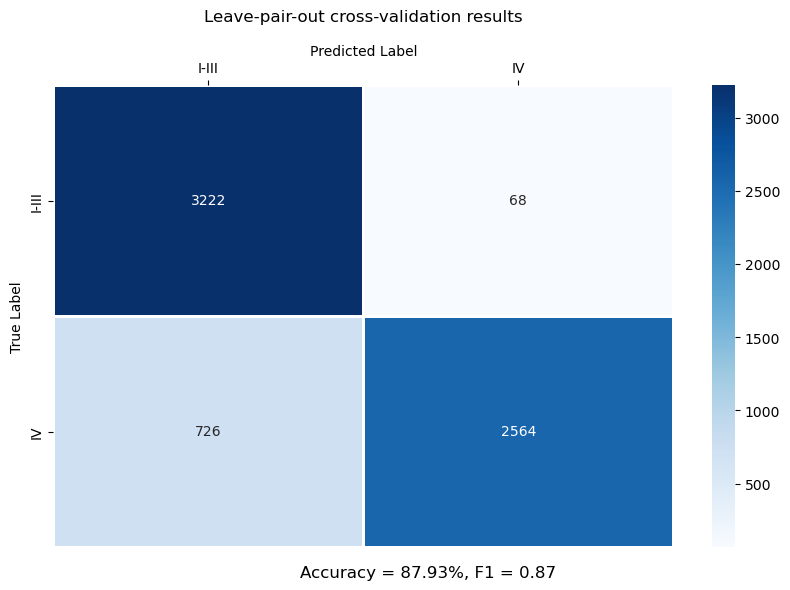

In [23]:
labels = list(labels_encoding_binary.keys())

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

title = f'Leave-pair-out cross-validation results'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
filename = f'LPOCV_results.png'

plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir, filename))

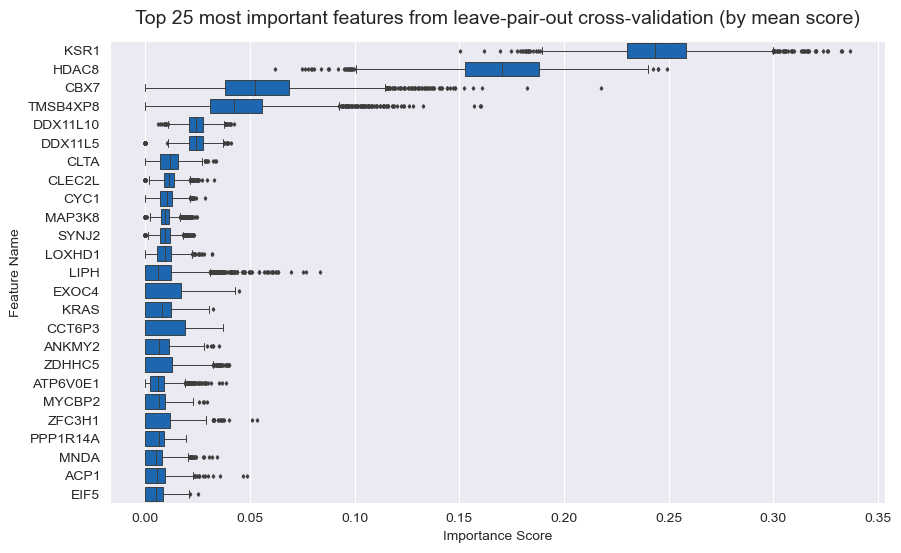

In [108]:
top_n = 25
filename = f'top_{top_n}_most_important_features.png'

plot_feature_importances(feature_importances_history, X.columns.to_numpy(), top_n=top_n, output_path=os.path.join(output_dir, filename))